In [38]:
'''
Created on 04.07.2017

@author: Roman
'''
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import skimage.data
import matplotlib

import skimage
import skimage.transform
import scipy
import skimage.io
import scipy.misc
import scipy.ndimage

def radon(input):
    # Use the same number of angles as the largest dimension of input
    theta = np.linspace(0, 180, max(input.shape), endpoint=False)
    
    # Pad input image
    diagonal = np.sqrt(input.shape[0]**2 + input.shape[1]**2)
    diagonali = int(np.ceil(diagonal))
    xpos = (diagonali - input.shape[0]) // 2
    ypos = (diagonali - input.shape[1]) // 2
    padded_image = np.zeros([diagonali, diagonali])
    padded_image[xpos:xpos+input.shape[0], ypos:ypos+input.shape[1]] = input
    
    # Calculate projections
    sinogram = np.zeros([padded_image.shape[0], len(theta)])
    for i in range(len(theta)):
        rotated = scipy.ndimage.rotate (padded_image, -theta[i], reshape=False, order=1, prefilter=False)
        sinogram[:, i] = rotated.sum(0)
        
    return sinogram


def iradon(sinogram):
    m, n = sinogram.shape
    output_size = output_size = int(np.floor(np.sqrt(m**2 / 2.0)))
    theta = np.linspace(0, 180, n, endpoint=False)
    th = (np.pi / 180.0) * theta
    reconstructed = np.zeros((output_size, output_size))
    mid_index = sinogram.shape[0] // 2

    [X, Y] = np.mgrid[0:output_size, 0:output_size]
    xpr = X - int(output_size) // 2
    ypr = Y - int(output_size) // 2

    for i in range(len(theta)):
        t = ypr * np.cos(th[i]) - xpr * np.sin(th[i])
        x = np.arange(m) - mid_index
        backprojected = np.interp(t, x, sinogram[:, i], left=0, right=0)
        reconstructed += backprojected

    return reconstructed * np.pi / (2 * len(th))

def filter_ramp(sinogram):
    freqs = sinogram.shape[0]
    freq = np.fft.fftfreq(freqs)
    omega = 2 * np.pi * freq
    filter = np.abs(omega)
    values = np.fft.fft(sinogram, axis=0)
    values = values * filter.reshape(-1, 1)
    values = np.fft.ifft (values, axis=0)
    values = values.real
    
    reconstructed = iradon(values)
    return reconstructed

def filter_ramlak(sinogram, omega0):
    freqs = sinogram.shape[0]
    freq = np.fft.fftfreq(freqs)
    omega = 2 * np.pi * freq
    filter = np.abs(omega) / omega0 * (np.abs(omega) <= omega0)
    values = np.fft.fft(sinogram, axis=0)
    values = values * filter.reshape(-1, 1)
    values = np.fft.ifft (values, axis=0)
    values = values.real
    
    reconstructed = iradon(values)
    return reconstructed

def mlem(sinogram,maxiter):
       
    print('Starting MLEM...')
    normimg = np.ones(sinogram.shape)
    normvol = iradon(normimg)
     
    result = np.ones(normvol.shape)
    for iter in range(0, maxiter):
        print ('Iteration %d/%d' % (iter + 1, maxiter))
        data = radon(result)
        data = sinogram / data
        data[np.logical_not(np.isfinite(data))] = 0 # Handle division by zero
        data = iradon (data)
        data = data / normvol
        data[np.logical_not(np.isfinite(data))] = 0 # Handle division by zero
        result = result * data

    return result
    
def atoi(a):
    i=200*np.exp((-1)*a)
    return i

def itoa(i):
    a=(-1)*np.log(i/200.0)
    return a

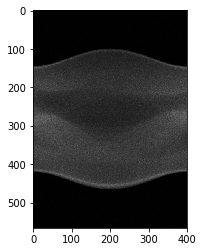

In [33]:
sinogram=skimage.io.imread('sinogram.png')
intensity=atoi(sinogram/np.mean(sinogram))
intensity_noise = np.random.poisson (intensity)
sinogram_noise =itoa(intensity_noise)
plt.figure(); plt.imshow(sinogram_noise/np.mean(sinogram_noise), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10)

Starting MLEM...
Iteration 1/5


C:\Users\Danie_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Danie_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5


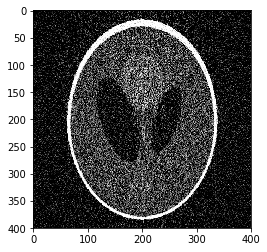

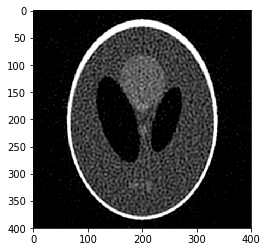

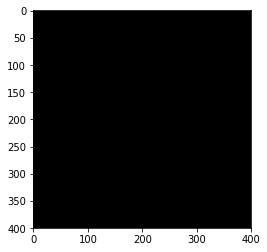

In [34]:
res_fil1 = filter_ramp(sinogram_noise) # Filtered backprojection (ramp filter)
res_fil2 = filter_ramlak(sinogram_noise,1) # Filtered backprojection (ramlak filter)
res_mlem = mlem(sinogram_noise,5) # MLEM

plt.figure(); plt.imshow(res_fil1/np.mean(res_fil1), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10)
plt.figure(); plt.imshow(res_fil2/np.mean(res_fil2), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10)
plt.figure(); plt.imshow(res_mlem/np.mean(res_mlem), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10) 

Starting MLEM...
Iteration 1/5


C:\Users\Danie_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5


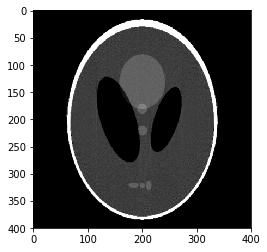

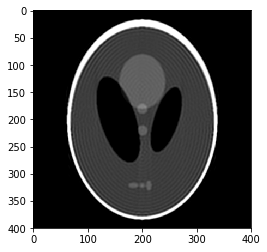

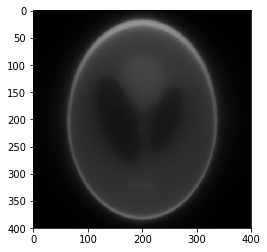

In [31]:
res_fil1 = filter_ramp(sinogram) # Filtered backprojection (ramp filter)
res_fil2 = filter_ramlak(sinogram,1) # Filtered backprojection (ramlak filter)
res_mlem = mlem(sinogram,5) # MLEM

plt.figure(); plt.imshow(res_fil1/np.mean(res_fil1), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10)
plt.figure(); plt.imshow(res_fil2/np.mean(res_fil2), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10)
plt.figure(); plt.imshow(res_mlem/np.mean(res_mlem), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10) 

In [44]:
def halfradon(input):
    # Use the same number of angles as the largest dimension of input
    theta = np.linspace(0, 90, max(input.shape), endpoint=False)
    
    # Pad input image
    diagonal = np.sqrt(input.shape[0]**2 + input.shape[1]**2)
    diagonali = int(np.ceil(diagonal))
    xpos = (diagonali - input.shape[0]) // 2
    ypos = (diagonali - input.shape[1]) // 2
    padded_image = np.zeros([diagonali, diagonali])
    padded_image[xpos:xpos+input.shape[0], ypos:ypos+input.shape[1]] = input
    
    # Calculate projections
    sinogram = np.zeros([padded_image.shape[0], len(theta)])
    for i in range(len(theta)):
        rotated = scipy.ndimage.rotate (padded_image, -theta[i], reshape=False, order=1, prefilter=False)
        sinogram[:, i] = rotated.sum(0)
        
    return sinogram

Starting MLEM...
Iteration 1/5


C:\Users\Danie_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Danie_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5


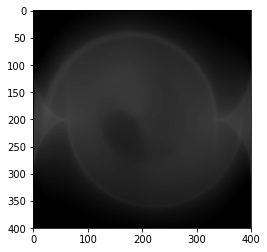

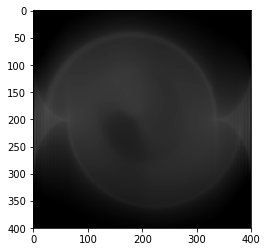

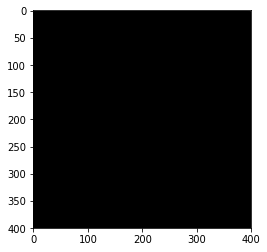

In [45]:
sinogram_half=halfradon(iradon(sinogram))
res_fil1 = filter_ramp(sinogram_half) # Filtered backprojection (ramp filter)
res_fil2 = filter_ramlak(sinogram_half,1) # Filtered backprojection (ramlak filter)
res_mlem = mlem(sinogram_half,5) # MLEM

plt.figure(); plt.imshow(res_fil1/np.mean(res_fil1), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10)
plt.figure(); plt.imshow(res_fil2/np.mean(res_fil2), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10)
plt.figure(); plt.imshow(res_mlem/np.mean(res_mlem), cmap=matplotlib.cm.Greys_r , vmin=0, vmax=10) 